### Makemore part 5

In [139]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import datetime
import torch.nn as nn
import torch.optim as optim
%matplotlib inline

In [5]:
words = open('names.txt').read().split()
print(words[:8])

chars = sorted(list(set(''.join(words))))
ch_to_i = {s: i+1 for i, s in enumerate(chars)}
ch_to_i['.'] = 0
i_to_ch = {i: s for s, i in ch_to_i.items()}
vocab_size = len(i_to_ch)

['pratap', 'ishwar', 'yasmin', 'mitesh', 'vikramendra', 'vineet', 'shrimat', 'rajhansa']


In [137]:
block_size = 8
n_embd = 24
n_hidden = 128
torch.manual_seed(42);
random.seed(42)

In [40]:
random.shuffle(words)
n1 = int(0.9*len(words))
n2 = int(0.98*len(words))

In [41]:
def build_dataset(words):
    
    X, Y = [], []

    for w in words:
 
        context = [0] * block_size
        for ch in w + '.':
            ix = ch_to_i[ch]
            X.append(context)
            Y.append(ix)
            
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

X_tr, y_tr = build_dataset(words[:n1])
X_dev, y_dev = build_dataset(words[n1:n2])
X_te, y_te = build_dataset(words[n2:])

torch.Size([50552, 8]) torch.Size([50552])
torch.Size([4400, 8]) torch.Size([4400])
torch.Size([1109, 8]) torch.Size([1109])


In [124]:
class FlattenConsecutive(nn.Module):

  def __init__(self, n):
    super().__init__()
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  

class BatchNorm1d(nn.Module):
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    super().__init__()
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]
  

In [145]:
model = nn.Sequential(
    nn.Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), 
    nn.Linear(n_embd * 2, n_hidden, bias=False), 
    BatchNorm1d(n_hidden), 
    nn.Tanh(),
    FlattenConsecutive(2), 
    nn.Linear(n_hidden * 2, n_hidden, bias=False), 
    BatchNorm1d(n_hidden), 
    nn.Tanh(),
    FlattenConsecutive(2), 
    nn.Linear(n_hidden * 2, n_hidden, bias=False), 
    BatchNorm1d(n_hidden), 
    nn.Tanh(),
    nn.Linear(n_hidden, vocab_size)
)

# parameter init
with torch.no_grad():
  model[-1].weight *= 0.1

In [146]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=35000, gamma=0.1)

In [147]:
max_steps = 50000
batch_size = 32

lossi = []
for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, X_tr.shape[0], (batch_size,))
  Xb, Yb = X_tr[ix], y_tr[ix] # batch X,Y
  
  optimizer.zero_grad()

  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  loss.backward()
  optimizer.step()

  # lv = split_loss('val')
  # track stats
  if i % 5000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    # print(f'{i:7d}/{max_steps:7d}: {lv.item():.4f}')

  
  lossi.append(loss.log10().item())
  # loss_val.append(lv.log10().item())

      0/  50000: 3.2973
   5000/  50000: 2.0290
  10000/  50000: 1.8019
  15000/  50000: 1.8063
  20000/  50000: 1.9734
  25000/  50000: 1.7538
  30000/  50000: 1.8057
  35000/  50000: 1.9867
  40000/  50000: 1.3184
  45000/  50000: 1.7955


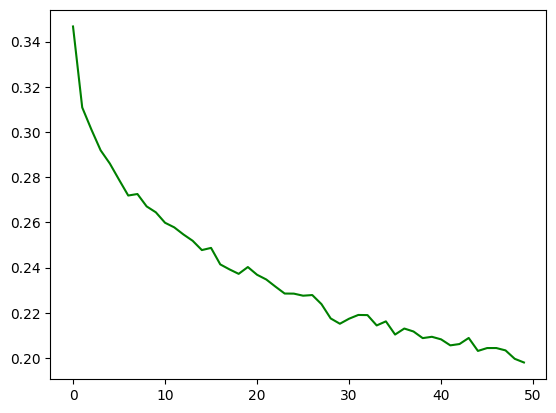

In [148]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1), c='green')

In [149]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model:
    layer.training = False
    
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (X_tr, y_tr),
    'val': (X_dev, y_dev),
    'test': (X_te, y_te),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  return loss

In [150]:
loss_tr = split_loss('train')
loss_val = split_loss('val')
print(loss_tr)
print(loss_val)

tensor(1.5487)
tensor(1.9867)


In [160]:
# sample from the model
with torch.no_grad():
  for _ in range(20):
      
      out = []
      context = [0] * block_size # initialize with all ...
      while True:
        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
          break
      
      print(''.join(i_to_ch[i] for i in out)) # decode and print the generated word

ganish.
panak.
sunil.
abeer.
surin.
meera.
hradbaha.
duruda.
usuni.
saravan.
vikshem.
toyesa.
kardarjay.
aranyuktamani.
arangoet.
virendra.
vyogalya.
mahada.
saarrendra.
dayant.


In [154]:

now = datetime.datetime.now()
now_dt_str = now.strftime('%Y-%m-%d %H%M%S')
PATH = "{}.pt".format(now_dt_str)

torch.save(model.state_dict(), 'models/{}'.format(PATH))


line = '{},{},{},{},{},{},{},{}\n'.format(PATH,
                                     block_size, 
                                     n_embd, 
                                     n_hidden, 
                                     max_steps, 
                                     batch_size, 
                                     loss_tr, 
                                     loss_val)

with open('models/training_details.csv', 'a+') as outfile:
  outfile.write(line)

In [165]:
torch.save(model, 'models/temp.pyt')

In [164]:
# Load
model_inf = nn.Sequential(
    nn.Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), 
    nn.Linear(n_embd * 2, n_hidden, bias=False), 
    BatchNorm1d(n_hidden), 
    nn.Tanh(),
    FlattenConsecutive(2), 
    nn.Linear(n_hidden * 2, n_hidden, bias=False), 
    BatchNorm1d(n_hidden), 
    nn.Tanh(),
    FlattenConsecutive(2), 
    nn.Linear(n_hidden * 2, n_hidden, bias=False), 
    BatchNorm1d(n_hidden), 
    nn.Tanh(),
    nn.Linear(n_hidden, vocab_size)
)
model_inf.load_state_dict(torch.load('models/{}'.format(PATH)))
for layer in model_inf:
    layer.training = False
model_inf.eval()

@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss_inf(split):
  x,y = {
    'train': (X_tr, y_tr),
    'val': (X_dev, y_dev),
    'test': (X_te, y_te),
  }[split]
  logits = model_inf(x)
  loss = F.cross_entropy(logits, y)
  return loss

loss_tr_inf = split_loss_inf('train')
loss_val_inf = split_loss_inf('val')
print(loss_tr_inf)
print(loss_val_inf)

# sample from the model
with torch.no_grad():
  for _ in range(20):
      
      out = []
      context = [0] * block_size # initialize with all ...
      while True:
        # forward pass the neural net
        logits = model_inf(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
          break
      
      print(''.join(i_to_ch[i] for i in out)) # decode and print the generated word


tensor(2.8783)
tensor(3.3423)
srigdshil.
gragrebihardhiprasad.
tnutbikdgayotti.
trnvantesh.
rhildsth.
rrichikmptrnqhirajjnwitm.
rchiraschinmndrthupta.
chetr.
ngnnadhankara.
smryrthamady.
khyannakshirajima.
trighnest.
rvnitraghrma.
rhditvshankth.
ryunika.
ghladbhadrmsurajendraj.
ryisthamagkaliksh.
rchilmsincj.
rjitisri.
rhillva.


In [166]:
model3 = torch.load('models/temp.pyt')
for layer in model3:
    layer.training = False
model3.eval()

@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss_inf(split):
  x,y = {
    'train': (X_tr, y_tr),
    'val': (X_dev, y_dev),
    'test': (X_te, y_te),
  }[split]
  logits = model3(x)
  loss = F.cross_entropy(logits, y)
  return loss

loss_tr_inf = split_loss_inf('train')
loss_val_inf = split_loss_inf('val')
print(loss_tr_inf)
print(loss_val_inf)

# sample from the model
with torch.no_grad():
  for _ in range(20):
      
      out = []
      context = [0] * block_size # initialize with all ...
      while True:
        # forward pass the neural net
        logits = model3(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
          break
      
      print(''.join(i_to_ch[i] for i in out)) # decode and print the generated word

tensor(1.5487)
tensor(1.9867)
vipluba.
vibhut.
bakrusha.
parang.
souchistha.
ritu.
aarukia.
kritunjal.
ruthesh.
suraagh.
ratgunarnan.
parvip.
parvika.
lakshmivara.
nabhi.
nitesh.
kusum.
tanir.
aachi.
tanisha.
